# Urbanization and Development Tier Clustering on House pricing

## Setup

### Imports

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score


from sklearn.model_selection import train_test_split

### Directories and files 

In [ ]:
cwd = os.getcwd()
DATA_DIR = os.path.join(cwd, "data")
PDATA_DIR = os.path.join(DATA_DIR, "processed")
CDATA_DIR = os.path.join(DATA_DIR, "clustering")
MASTER_DF_FILE = os.path.join(PDATA_DIR, "master_dataset.csv")

### Constants

In [6]:
SEED = 42
SPLIT_SIZE = 0.2
MAX_ITER = 5000
ALPHAS = np.logspace(-6, 6, 40)

scaler = StandardScaler()
results = {
    "all": {},
    "2023": {}
}

In [7]:
# plots
FIGSIZE = (10, 5)
TITLE_FONTSIZE = 16
AXIS_LABEL_FONSIZE = 15

# multiple plots
FIGSIZE_2 = (18, 7)
FIGSIZE_3 = (18, 5)

### Data & columns

In [8]:
df = pd.read_csv(MASTER_DF_FILE).drop(columns=("Unnamed: 0"))

In [9]:
SERVICE_COLUMNS = [
    "cinema", "college", "courthouse", "fire_station", "hospital",
    "kindergarten", "library", "mall", "museum", "pharmacy", "police",
    "post_office", "school", "station", "theatre", "university"
]

AGE_COLUMNS = [
    '< 5', '6 - 19', '20-34', '35 - 54', '> 55'
]  

WEATHER_RAW_COLUMNS = ["total_sunshine_h", "mean_sunshine_h", "windspeed_mean_kmh", "total_precipitation_mm", "mean_precipitation_mm"]
WEATHER_DAYS_COLUMNS = ["windy_days", "rainy_days", "sunny_days", "warm_days"]
WEATHER_COLUMNS = WEATHER_RAW_COLUMNS + WEATHER_DAYS_COLUMNS


INCOME_COLUMN = "avg_income"
POP_DENSITY_COLUMN = "people/km2"
TIME_COLUMNS = ["quarter_num", "quarter_ord"]

## Urbanization, development tier

Urban scoring would depend on the population density, average income and the amenities (they will indicate how well the municipality is developed). We expect to get at least 3 distinct clusters: metropolis (Porto, Lisbon), urban (Aveiro) and rural (small villages/towns).

In [ ]:
urban_clusters = {}
urban_features = [POP_DENSITY_COLUMN, INCOME_COLUMN] + SERVICE_COLUMNS

X = df[urban_features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### PCA (Data visualization: Urbanization and development factors)

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"Explained variance ratio: {pca.explained_variance_ratio_[0]*100:.2f}% by PC1 (Infrastructure) and {pca.explained_variance_ratio_[1]*100:.2f}% by PC2")
print(f"Total explained variance ratio: {sum(pca.explained_variance_ratio_)*100:.2f}%")

Explained variance ratio: 74.84% by PC1 (Infrastructure) and 6.65% by PC2
Total explained variance ratio: 81.49%


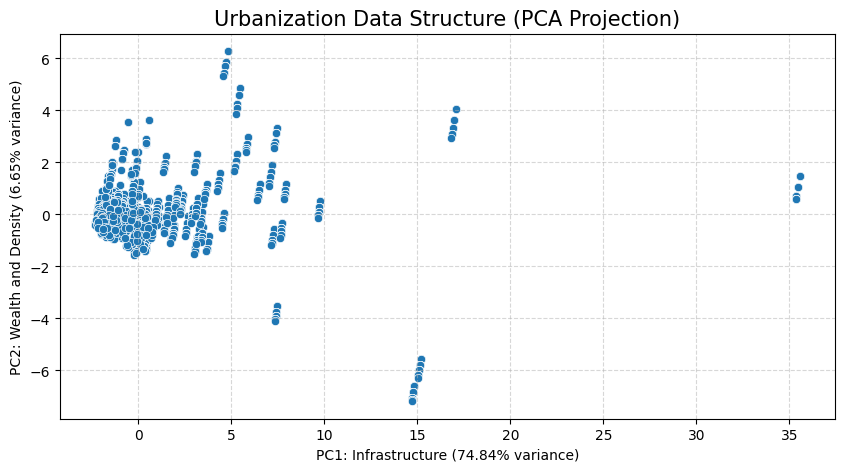

In [14]:
plt.figure(figsize=FIGSIZE)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1])
plt.title('Urbanization Data Structure (PCA Projection)', fontsize=15)
plt.xlabel(f'PC1: Infrastructure ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2: Wealth and Density ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Clustering

#### Algorithm choice

In [15]:
# K-Means (Spherical)
kmeans = KMeans(n_clusters=3, random_state=SEED, n_init=10)
labels_km = kmeans.fit_predict(X_scaled)
score_km = silhouette_score(X_scaled, labels_km)

# GMM (Ellipsoidal)
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=SEED)
labels_gmm = gmm.fit_predict(X_scaled)
score_gmm = silhouette_score(X_scaled, labels_gmm)

# DBSCAN (Arbitrary)
dbs = DBSCAN(eps=3.5, min_samples=10)
labels_db = dbs.fit_predict(X_scaled)
score_db = silhouette_score(X_scaled, labels_db)

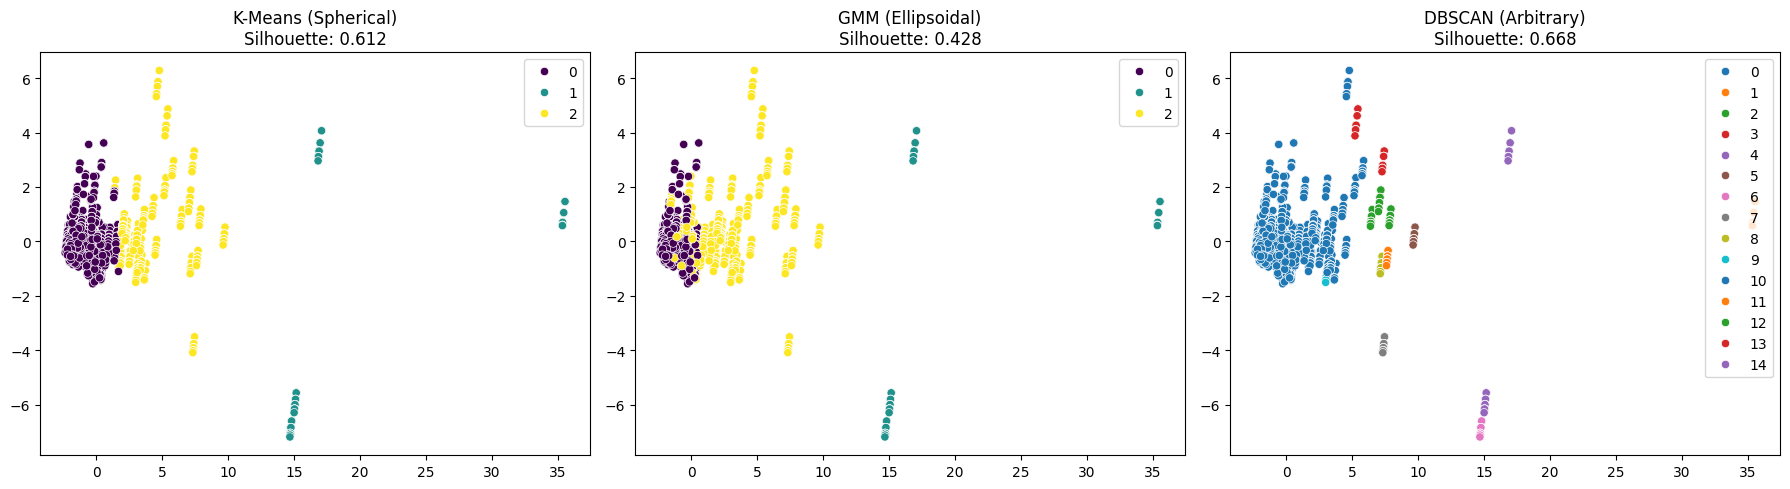

In [16]:
fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_3)

# Plot K-Means
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_km, palette='viridis', ax=axes[0])
axes[0].set_title(f'K-Means (Spherical)\nSilhouette: {score_km:.3f}')

# Plot GMM
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_gmm, palette='viridis', ax=axes[1])
axes[1].set_title(f'GMM (Ellipsoidal)\nSilhouette: {score_gmm:.3f}')

# Plot DBSCAN
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_db, palette='tab10', ax=axes[2])
axes[2].set_title(f'DBSCAN (Arbitrary)\nSilhouette: {score_db:.3f}')

plt.tight_layout()
plt.show()

#### Choosing the number of clusters

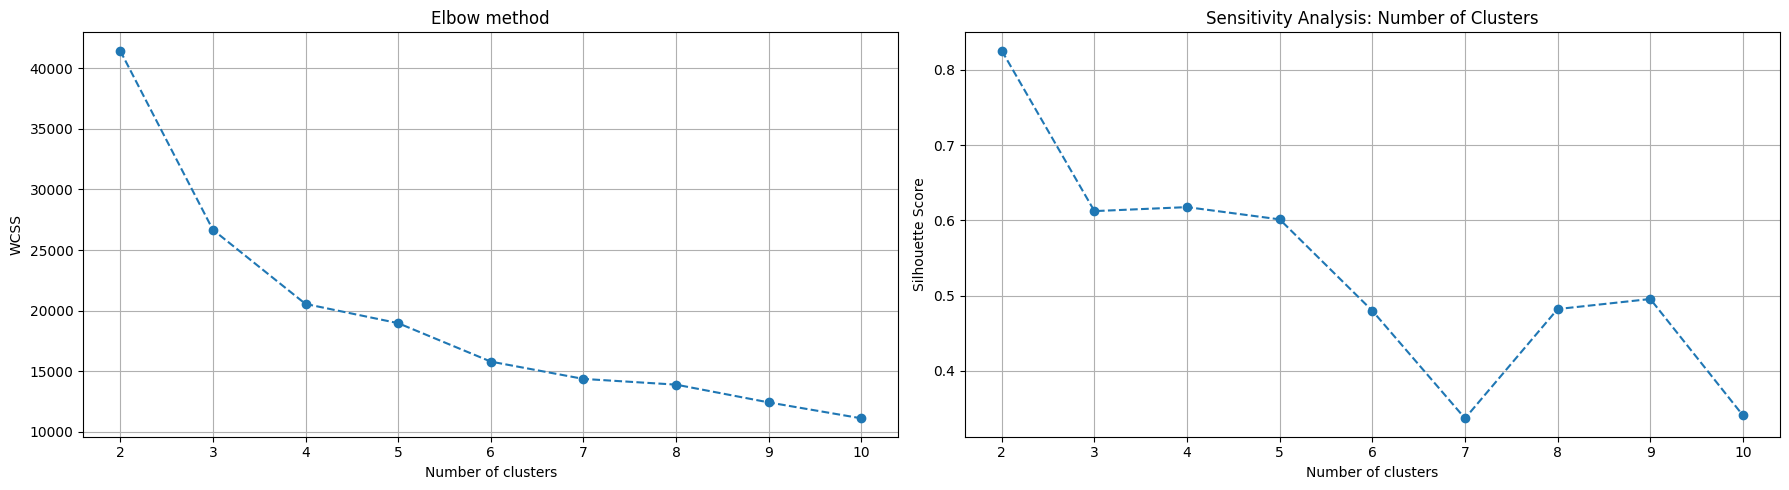

In [17]:
cluster_range = range(2, 11)
silhouette_scores = []
wcss = []

for i in cluster_range:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    # sensitivity analysis for number of cluster
    kmeans_labels = kmeans.predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, kmeans_labels)
    silhouette_scores.append(silhouette_avg)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))


axes[0].set_title('Elbow method')
axes[0].plot(cluster_range, wcss, marker='o', linestyle='--')
axes[0].set(xlabel="Number of clusters", ylabel="WCSS")
axes[0].grid(True)

axes[1].set_title("Sensitivity Analysis: Number of Clusters")
axes[1].plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
axes[1].set(xlabel="Number of clusters", ylabel="Silhouette Score")
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### Clustering: 6 clusters

In [18]:
n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10)
labels_km = kmeans.fit_predict(X_scaled)
score_km = silhouette_score(X_scaled, labels_km)
df['DC6'] = labels_km # DC -> Development Cluster

print(f"Silhuette Score: {score_km:.3f}")
summary = df.groupby('DC6')[[POP_DENSITY_COLUMN, INCOME_COLUMN, 'school', 'hospital', "university"]].mean()
print("Cluster Profiles:")
summary

Silhuette Score: 0.476
Cluster Profiles:


,people/km2,avg_income,school,hospital,university
DC6,,,,,
0,124.853846,1070.461705,19.301365,0.787546,0.220446
1,2008.756303,1344.183613,163.428571,8.357143,9.214286
2,5547.964706,1815.070588,431.000000,39.000000,53.000000
3,5793.782353,1599.523529,213.000000,20.000000,43.000000
4,394.278988,1205.074847,78.702454,3.725460,2.608896
5,90.455882,1162.779412,261.500000,13.500000,10.000000


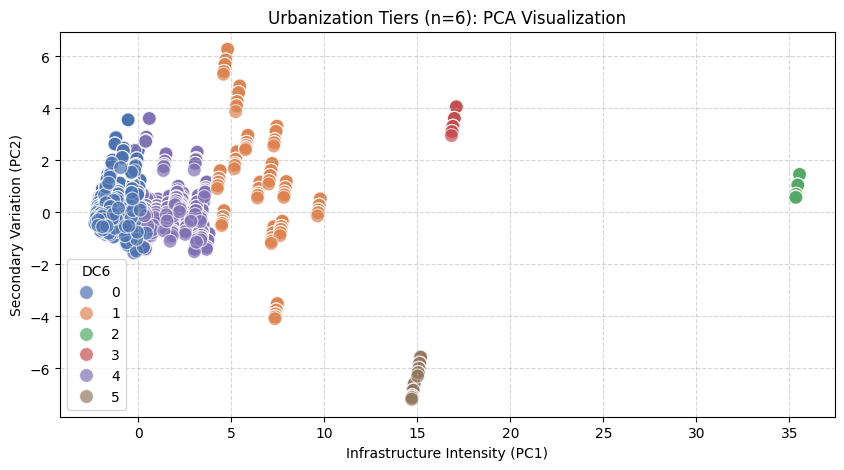

In [19]:
plt.figure(figsize=FIGSIZE)
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=df['DC6'], 
    palette="deep",
    s=100,
    alpha=0.7
)
plt.title('Urbanization Tiers (n=6): PCA Visualization')
plt.xlabel('Infrastructure Intensity (PC1)')
plt.ylabel('Secondary Variation (PC2)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [20]:
for i in range(n_clusters):
    cluster_municipalities = pd.Series(df[df["DC6"] == i]["municipality"].unique())
    print(f"\nCluster {i}: {cluster_municipalities.count()} municipalities assigned.\n")
    if cluster_municipalities.count() < 15:
        print(cluster_municipalities)
    else:
        print(cluster_municipalities.head())


Cluster 0: 176 municipalities assigned.

0    Arcos de Valdevez
1     Paredes de Coura
2       Ponte da Barca
3        Ponte de Lima
4              Valença
dtype: object

Cluster 1: 14 municipalities assigned.

0                 Braga
1             Guimarães
2              Gondomar
3                  Maia
4            Matosinhos
5     Vila Nova de Gaia
6              Bragança
7               Coimbra
8               Amadora
9               Cascais
10               Loures
11               Oeiras
12               Sintra
13               Almada
dtype: object

Cluster 2: 1 municipalities assigned.

0    Lisboa
dtype: object

Cluster 3: 1 municipalities assigned.

0    Porto
dtype: object

Cluster 4: 41 municipalities assigned.

0          Viana do Castelo
1                  Barcelos
2                Vila Verde
3    Vila Nova de Famalicão
4                    Arouca
dtype: object

Cluster 5: 2 municipalities assigned.

0     Vila Real
1    Portalegre
dtype: object


In [21]:
urban_clusters[6] = {
    2: 'Tier1_Capital',
    3: 'Tier2_MajorCity',
    1: 'Tier3_DenseSuburb',
    5: 'Tier4_HistoricHub',   # The low density / high amenity outlier
    4: 'Tier5_Urban',
    0: 'Tier6_Rural'
}

df['DC6_name'] = df['DC6'].map(urban_clusters[6])

In [22]:
df_urban6 = pd.get_dummies(df, columns=['DC6_name'], drop_first=False, prefix="DC6")
df_urban6.head()

df_urban6.to_csv(os.path.join(CDATA_DIR, 'cluster_urban6.csv'), index=False)

#### Clustering: 3 clusters

In [23]:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10)
labels_km = kmeans.fit_predict(X_scaled)
score_km = silhouette_score(X_scaled, labels_km)
df['DC3'] = labels_km # DC -> Development Cluster

print(f"Silhuette Score: {score_km:.3f}")
summary = df.groupby('DC3')[[POP_DENSITY_COLUMN, INCOME_COLUMN, 'school', 'hospital', "university"]].mean()
print("Cluster Profiles:")
summary

Silhuette Score: 0.612
Cluster Profiles:


,people/km2,avg_income,school,hospital,university
DC3,,,,,
0,138.077642,1083.308663,24.013099,1.030366,0.417684
1,2880.664706,1435.038235,291.750000,21.500000,29.000000
2,1210.275655,1276.005993,126.426966,6.220974,5.904494


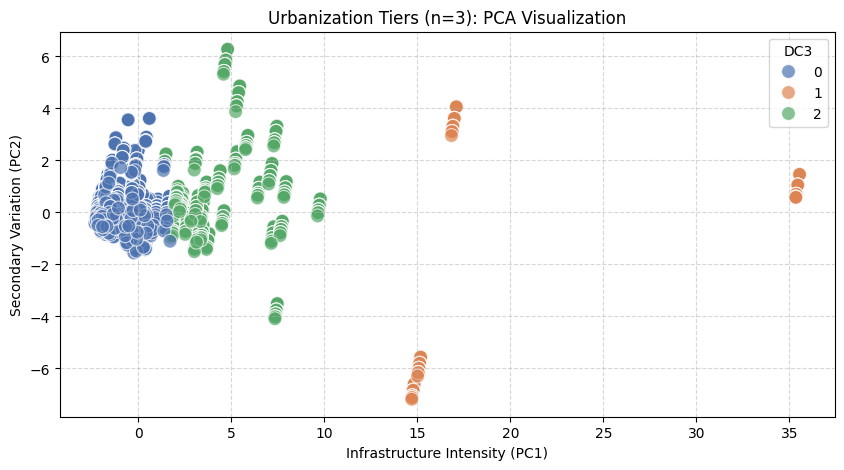

In [24]:
plt.figure(figsize=FIGSIZE)
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=df['DC3'], 
    palette="deep",
    s=100,
    alpha=0.7
)
plt.title('Urbanization Tiers (n=3): PCA Visualization')
plt.xlabel('Infrastructure Intensity (PC1)')
plt.ylabel('Secondary Variation (PC2)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [25]:
for i in range(n_clusters):
    cluster_municipalities = pd.Series(df[df["DC6"] == i]["municipality"].unique())
    print(f"\nCluster {i}: {cluster_municipalities.count()} municipalities assigned.\n")
    if cluster_municipalities.count() < 15:
        print(cluster_municipalities)
    else:
        print(cluster_municipalities.head())


Cluster 0: 176 municipalities assigned.

0    Arcos de Valdevez
1     Paredes de Coura
2       Ponte da Barca
3        Ponte de Lima
4              Valença
dtype: object

Cluster 1: 14 municipalities assigned.

0                 Braga
1             Guimarães
2              Gondomar
3                  Maia
4            Matosinhos
5     Vila Nova de Gaia
6              Bragança
7               Coimbra
8               Amadora
9               Cascais
10               Loures
11               Oeiras
12               Sintra
13               Almada
dtype: object

Cluster 2: 1 municipalities assigned.

0    Lisboa
dtype: object


In [26]:
urban_clusters[3] = {
    0: "Tier3__Rural",
    2: "Tier2__Urban",
    1: "Tier1__City"
}

df['DC3_name'] = df['DC3'].map(urban_clusters[3])


df_urban3 = pd.get_dummies(df, columns=['DC3_name'], drop_first=False, prefix="DC3")
df_urban3.head()

df_urban3.to_csv(os.path.join(CDATA_DIR, 'cluster_urban3.csv'), index=False)

### Regression for clustered data

#### For 6 urban clusters

In [27]:
N = 6

dc_columns = df_urban6.filter(regex="DC6_").columns.to_list()
features = WEATHER_COLUMNS + TIME_COLUMNS + AGE_COLUMNS + dc_columns

X = df_urban6[features]
y = df_urban6['log_price_sqm']

scaler_urb = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_SIZE, random_state=SEED)
X_train_scaled = scaler_urb.fit_transform(X_train)
X_test_scaled = scaler_urb.transform(X_test)

urb_reg_features = scaler_urb.get_feature_names_out()

In [28]:
# Linear Regression (Baseline)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# ElasticNetCV (Regularized Linear)
en = ElasticNetCV(cv=5, random_state=SEED, max_iter=MAX_ITER)
en.fit(X_train_scaled, y_train)

# Gradient Boosting (Non-Linear)
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=SEED)
gbr.fit(X_train_scaled, y_train)

models = {'Linear Regression': lr, 'ElasticNetCV': en, 'Gradient Boosting': gbr}
print(f"{'Model':<20} | {'RMSE':<8} | {'R2 Score':<8}")
print("-" * 42)

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name:<20} | {rmse:.4f}   | {r2:.4f}")

Model                | RMSE     | R2 Score
------------------------------------------
Linear Regression    | 0.4007   | 0.5065
ElasticNetCV         | 0.4013   | 0.5050
Gradient Boosting    | 0.2335   | 0.8324


In [29]:
en_coefs = en.coef_
gbr_coefs = gbr.feature_importances_

In [30]:
importance = pd.DataFrame({"feature": X.columns, "en_coefs": en_coefs, "gbr_coefs": gbr_coefs})
# importance

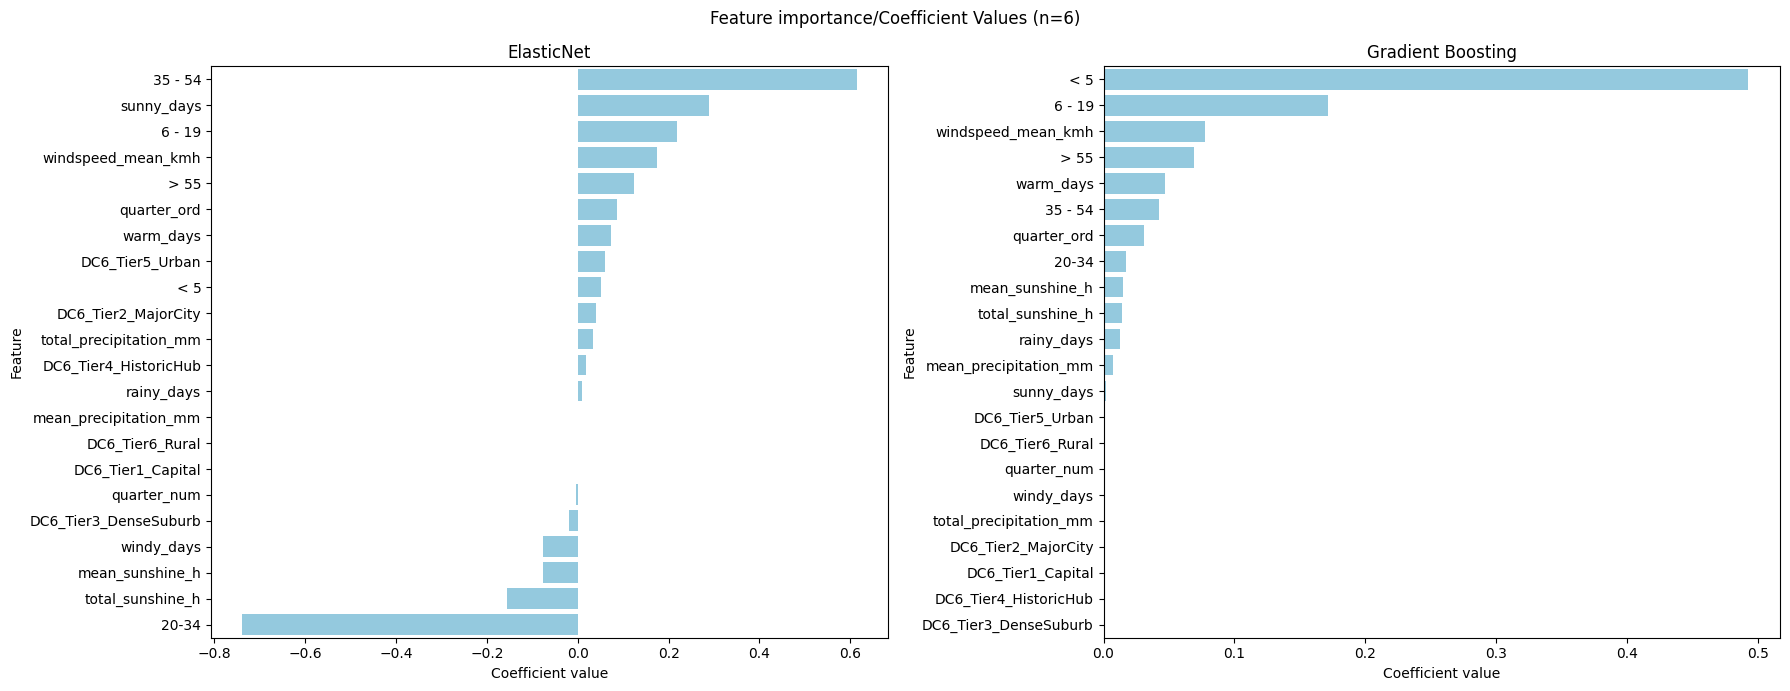

In [31]:
en_coefs_sorted = importance.sort_values("en_coefs", ascending=False)
gbr_coef_df = importance.sort_values("gbr_coefs", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_2)

sns.barplot(data=en_coefs_sorted, x="en_coefs", y="feature", color="skyblue", ax = axes[0])
axes[0].set_title("ElasticNet")
axes[0].set(xlabel="Coefficient value", ylabel="Feature")

sns.barplot(data=gbr_coef_df, x="gbr_coefs", y="feature", color="skyblue", ax = axes[1])
axes[1].set_title("Gradient Boosting")
axes[1].set(xlabel="Coefficient value", ylabel="Feature")

fig.suptitle(f"Feature importance/Coefficient Values (n={N})")
plt.tight_layout()
plt.show()

#### For 3 clusters

In [32]:
N = 3

dc_columns = df_urban3.filter(regex="DC3_").columns.to_list()
features = WEATHER_COLUMNS + TIME_COLUMNS + AGE_COLUMNS + dc_columns

X = df_urban3[features]
y = df_urban3['log_price_sqm']

scaler_urb = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_SIZE, random_state=SEED)
X_train_scaled = scaler_urb.fit_transform(X_train)
X_test_scaled = scaler_urb.transform(X_test)

urb_reg_features = scaler_urb.get_feature_names_out()

In [33]:
# Linear Regression (Baseline)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# ElasticNetCV (Regularized Linear)
en = ElasticNetCV(cv=5, random_state=SEED, max_iter=MAX_ITER)
en.fit(X_train_scaled, y_train)

# Gradient Boosting (Non-Linear)
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=SEED)
gbr.fit(X_train_scaled, y_train)

models = {'Linear Regression': lr, 'ElasticNetCV': en, 'Gradient Boosting': gbr}
print(f"{'Model':<20} | {'RMSE':<8} | {'R2 Score':<8}")
print("-" * 42)

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name:<20} | {rmse:.4f}   | {r2:.4f}")

Model                | RMSE     | R2 Score
------------------------------------------
Linear Regression    | 0.4070   | 0.4910
ElasticNetCV         | 0.4080   | 0.4884
Gradient Boosting    | 0.2324   | 0.8340


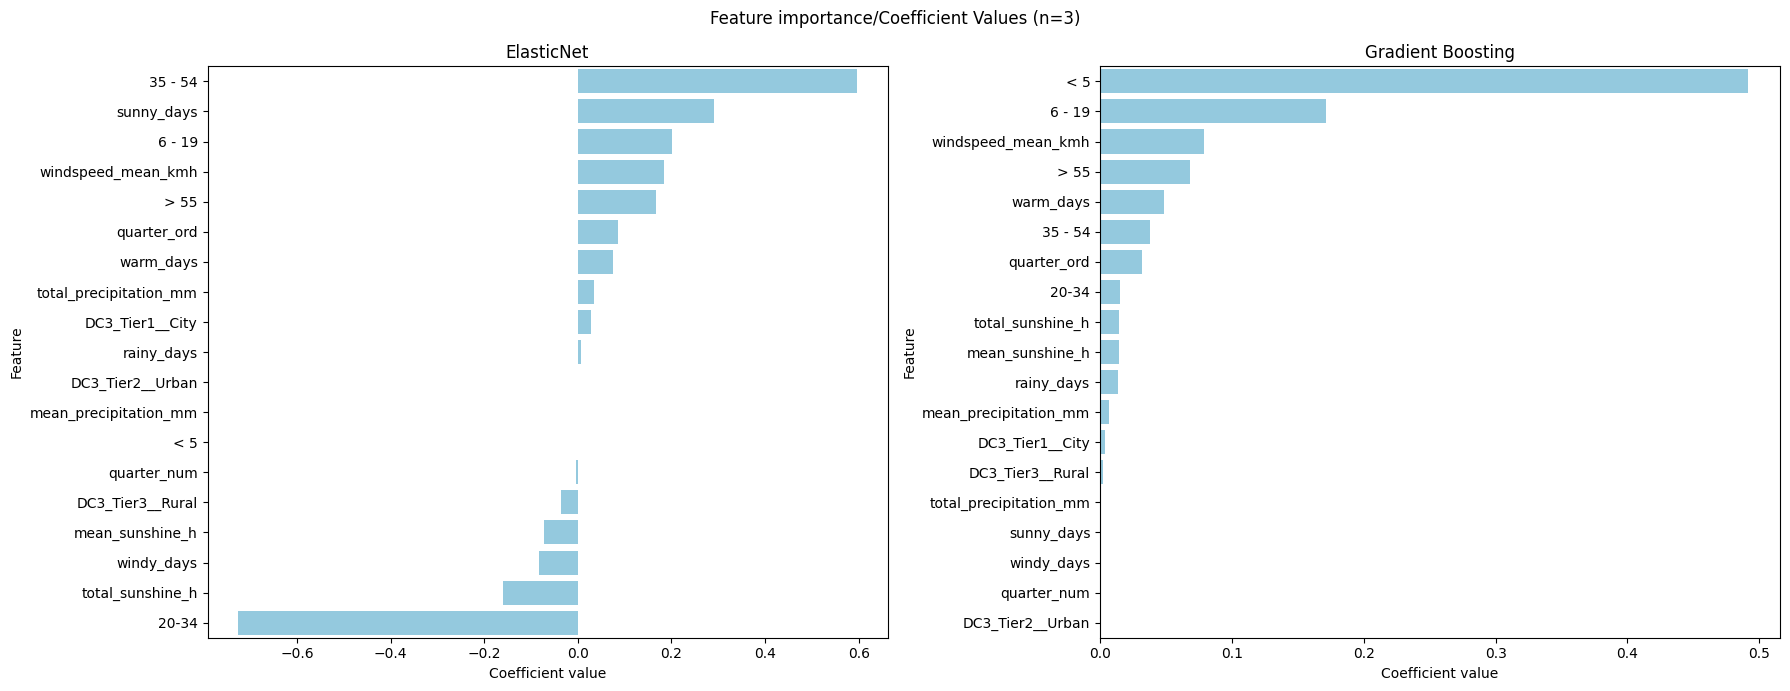

In [34]:
en_coefs = en.coef_
gbr_coefs = gbr.feature_importances_
importance = pd.DataFrame({"feature": X.columns, "en_coefs": en_coefs, "gbr_coefs": gbr_coefs})
# importance
en_coefs_sorted = importance.sort_values("en_coefs", ascending=False)
gbr_coef_df = importance.sort_values("gbr_coefs", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_2)

sns.barplot(data=en_coefs_sorted, x="en_coefs", y="feature", color="skyblue", ax = axes[0])
axes[0].set_title("ElasticNet")
axes[0].set(xlabel="Coefficient value", ylabel="Feature")

sns.barplot(data=gbr_coef_df, x="gbr_coefs", y="feature", color="skyblue", ax = axes[1])
axes[1].set_title("Gradient Boosting")
axes[1].set(xlabel="Coefficient value", ylabel="Feature")

fig.suptitle(f"Feature importance/Coefficient Values (n={N})")
plt.tight_layout()
plt.show()

## Demographic profiling

In [111]:
df.columns

Index(['municipality', 'house_price', 'total_sunshine_h', 'mean_sunshine_h',
       'windspeed_mean_kmh', 'total_precipitation_mm', 'mean_precipitation_mm',
       'windy_days', 'rainy_days', 'sunny_days', 'warm_days', 'year',
       'quarter_num', 'quarter_ord', 'avg_income', 'people/km2', '< 5',
       '6 - 19', '20-34', '35 - 54', '> 55', 'cinema', 'college', 'courthouse',
       'fire_station', 'hospital', 'kindergarten', 'library', 'mall', 'museum',
       'pharmacy', 'police', 'post_office', 'school', 'station', 'theatre',
       'university', 'log_price_sqm'],
      dtype='object')

In [116]:
age_columns = ["6 - 19", "< 5", "20-34", "35 - 54", "> 55"]
df['total_pop'] = df[age_columns].sum(axis=1)

X_demo = df[age_columns].div(df['total_pop'], axis=0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_demo)

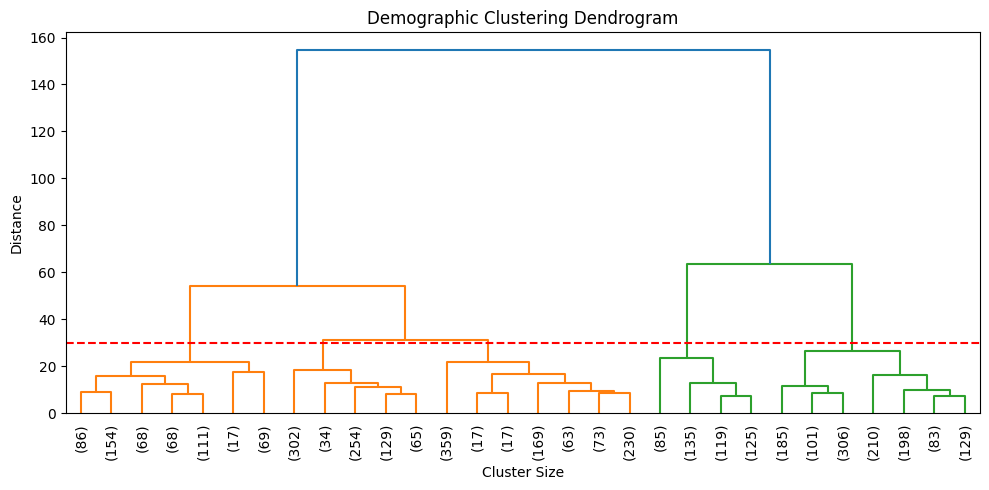

--- Cluster Profiles (Average % of Population) ---
              6 - 19  < 5  20-34  35 - 54  > 55
demo_cluster                                   
0               14.3  4.1   16.0     28.4  37.1
1               11.8  3.2   13.3     24.9  46.8
2                9.2  2.5   11.4     21.5  55.4


In [120]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# 4. Generate the Dendrogram (Tree Diagram)
# This helps visualize how the algorithm groups towns step-by-step
plt.figure(figsize=(10, 5))
Z = linkage(X_scaled, method='ward')
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title('Demographic Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.axhline(y=30, color='r', linestyle='--') # Cut-off line example
plt.tight_layout()
plt.savefig('dendrogram.png')
plt.show()

# 5. Apply the Clustering (Agglomerative)
# We choose 3 clusters to find distinct generational profiles
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
df['demo_cluster'] = hc.fit_predict(X_scaled)

# 6. Analyze the Results
# We look at the average age breakdown for each cluster
# Note: calculating the mean of the percentages we created earlier
cluster_profile = X_demo.groupby(df['demo_cluster']).mean() * 100
print("--- Cluster Profiles (Average % of Population) ---")
print(cluster_profile.round(1))

# 7. Label the Clusters
# (You can update these strings based on the printout above)
# Example logic based on the typical output:
# - High '> 55' = "Retirement Hub"
# - High '20-34' & '< 5' = "Young Families"
# - Balanced = "Working Age / Mixed"

> TODO: Add distribution

In [118]:
cluster_profile

,6 - 19,< 5,20-34,35 - 54,> 55
demo_cluster,,,,,
0,14.336841,4.121694,15.994348,28.434655,37.112462
1,11.799488,3.155455,13.310885,24.893225,46.840946
2,9.157423,2.474614,11.408827,21.515671,55.443465


In [122]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



# Scale & Cluster
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_demo)
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
df['cluster_id'] = hc.fit_predict(X_scaled)

# 3. Label the Clusters (Automated)
# We look at the mean age stats to name them dynamically
means = df.groupby('cluster_id')[X_demo.columns].mean()
id_young = means['< 5'].idxmax()     # The cluster with most babies
id_senior = means['> 55'].idxmax()   # The cluster with most seniors

# Map IDs to Names
label_map = {}
for cid in means.index:
    if cid == id_young:
        label_map[cid] = 'Demographic_YoungFamilies'
    elif cid == id_senior:
        label_map[cid] = 'Demographic_SeniorHub'
    else:
        label_map[cid] = 'Demographic_Transition'

df['demo_profile'] = df['cluster_id'].map(label_map)

# 4. Regression Analysis
# Question: "Does the Demographic Profile affect Price, controlling for Density?"
# We use One-Hot Encoding for the profiles
dummies = pd.get_dummies(df['demo_profile'], drop_first=True)
features = ['people/km2', 'avg_income', 'year']
X = pd.concat([df[features], dummies], axis=1)
y = df['log_price_sqm']

# Create interaction: Is the price trend (Year) steeper for Young Families?
df['Young_x_Year'] = df['demo_profile'].apply(lambda x: 1 if x == 'Demographic_YoungFamilies' else 0) * df['year']

# Add this new feature to your X
X['Young_x_Year'] = df['Young_x_Year']

# Fit Model
model = LinearRegression()
model.fit(X, y)

# 5. Output Insights
print("--- Impact of Demographics on Price (Coefficients) ---")
coeffs = pd.DataFrame(model.coef_, X.columns, columns=['Impact'])
print(coeffs)

# Identify Baseline
baseline = set(label_map.values()) - set(dummies.columns)
print(f"\nBaseline (Reference Group): {list(baseline)[0]}")

--- Impact of Demographics on Price (Coefficients) ---
                               Impact
people/km2                   0.000161
avg_income                   0.000431
year                         0.014114
Demographic_YoungFamilies -100.273805
Young_x_Year                 0.049878

Baseline (Reference Group): Demographic_Transition


combine urbanization and age

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 1. Load Data
df = pd.read_csv('master_dataset.csv')

# --- CLUSTER 1: URBANIZATION (The Hardware) ---
amenity_cols = [
    'cinema', 'college', 'courthouse', 'fire_station', 'hospital', 
    'kindergarten', 'library', 'mall', 'museum', 'pharmacy', 
    'police', 'post_office', 'school', 'station', 'theatre', 'university'
]
X_urb = StandardScaler().fit_transform(df[['people/km2', 'avg_income'] + amenity_cols])
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['urban_id'] = kmeans.fit_predict(X_urb)

# Auto-label Urban
urb_stats = df.groupby('urban_id')['avg_income'].mean().sort_values()
urb_map = {
    urb_stats.index[0]: 'Type_Rural',
    urb_stats.index[1]: 'Type_Town',
    urb_stats.index[2]: 'Type_City'
}
df['urban_tier'] = df['urban_id'].map(urb_map)

# --- CLUSTER 2: DEMOGRAPHICS (The Software) ---
age_cols = ['< 5', '6 - 19', '20-34', '35 - 54', '> 55']
df['total_pop'] = df[age_cols].sum(axis=1)
X_demo = df[age_cols].div(df['total_pop'], axis=0) # Percentages
X_demo_scaled = StandardScaler().fit_transform(X_demo)

# Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=3)
df['demo_id'] = hc.fit_predict(X_demo_scaled)

# Auto-label Demographics
demo_means = df.groupby('demo_id')[X_demo.columns].mean()
id_senior = demo_means['> 55'].idxmax()
id_young = demo_means['< 5'].idxmax()
id_work = list(set(demo_means.index) - {id_senior, id_young})[0]

demo_map = {
    id_senior: 'Pop_Senior',
    id_young: 'Pop_YoungFamilies',
    id_work: 'Pop_Workforce'
}
df['demo_profile'] = df['demo_id'].map(demo_map)

# --- COMBINED REGRESSION ---
# Features: Weather + Time + Urban Type + Demographic Type
reg_cols = ['mean_sunshine_h', 'year']
# One-Hot Encode both cluster columns
X = pd.concat([
    df[reg_cols],
    pd.get_dummies(df['urban_tier'], drop_first=True),
    pd.get_dummies(df['demo_profile'], drop_first=True)
], axis=1)
y = df['log_price_sqm']

# Run
model = LinearRegression()
model.fit(X, y)

# Output Coefficients
print(pd.DataFrame(model.coef_, X.columns, columns=['Impact_on_Price']))